## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, sys
from IPython import embed
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import clone 
from sklearn import tree
import eli5
from eli5.sklearn import PermutationImportance
import pydot
import pydotplus

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Preprocessing
Read data to pandas dataframe

In [2]:
data_dir = '../data/S3/AppEventData/'
CommunityMember = pd.read_csv(data_dir+'CommunityMember.csv', sep=',', quotechar='"', index_col=0)
SubscriptionHistory = pd.read_csv(data_dir+'SubscriptionHistory.csv', sep=',', quotechar='"', index_col=0)

iosActivityComplete = pd.read_csv(data_dir+'ios.activity_complete.csv', sep=',', quotechar='"', index_col=0)
iosSessionCompleted = pd.read_csv(data_dir+'ios.session_completed.csv', sep=',', quotechar='"', index_col=0)
iosLibrarySelectedTab = pd.read_csv(data_dir+'ios.library_selected_tab.csv', sep=',', quotechar='"', index_col=0)
iosScreenViewed = pd.read_csv(data_dir+'ios.screen_viewed.csv', sep=',', quotechar='"', index_col=0)
iosAppForeground = pd.read_csv(data_dir+'ios.app_enter_foreground.csv', sep=',', quotechar='"', index_col=0)
iosSessionViewed = pd.read_csv(data_dir+'ios.session_element_viewed.csv', sep=',', quotechar='"', index_col=0)

androidActivityComplete   = pd.read_csv(data_dir+'ongo_android.activity_complete.csv', sep=',', quotechar='"', index_col=0)
androidSessionCompleted   = pd.read_csv(data_dir+'ongo_android.session_completed.csv', sep=',', quotechar='"', index_col=0)
androidLibrarySelectedTab = pd.read_csv(data_dir+'ongo_android.library_selected_tab.csv', sep=',', quotechar='"', index_col=0)
androidScreenViewed       = pd.read_csv(data_dir+'ongo_android.screen_viewed.csv', sep=',', quotechar='"', index_col=0)
androidAppForeground      = pd.read_csv(data_dir+'ongo_android.app_enter_foreground.csv', sep=',', quotechar='"', index_col=0)
androidSessionViewed = pd.read_csv(data_dir+'ongo_android.session_element_viewed.csv', sep=',', quotechar='"', index_col=0)

treActivityComplete   = pd.read_csv(data_dir+'tre.activity_complete.csv', sep=',', quotechar='"', index_col=0)
treSessionCompleted   = pd.read_csv(data_dir+'tre.session_completed.csv', sep=',', quotechar='"', index_col=0)
treScreenViewed       = pd.read_csv(data_dir+'tre.screen_viewed.csv', sep=',', quotechar='"', index_col=0)
treSessionViewed = pd.read_csv(data_dir+'tre.session_element_viewed.csv', sep=',', quotechar='"', index_col=0)

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Format date data types

In [3]:
SubscriptionHistory.eventDate = pd.to_datetime(SubscriptionHistory.eventDate)
SubscriptionHistory.eventDate = SubscriptionHistory.eventDate.dt.normalize()
iosActivityComplete['received_at'] = pd.to_datetime(iosActivityComplete['received_at'])
iosSessionCompleted['received_at'] = pd.to_datetime(iosSessionCompleted['received_at'])
iosLibrarySelectedTab['received_at'] = pd.to_datetime(iosLibrarySelectedTab['received_at'])
iosScreenViewed['received_at'] = pd.to_datetime(iosScreenViewed['received_at'])
iosAppForeground['received_at'] = pd.to_datetime(iosAppForeground['received_at'])
iosSessionViewed['received_at'] = pd.to_datetime(iosSessionViewed['received_at'])

androidActivityComplete['received_at']   = pd.to_datetime(androidActivityComplete['received_at']).dt.normalize()
androidSessionCompleted['received_at']   = pd.to_datetime(androidSessionCompleted['received_at']).dt.normalize()
androidLibrarySelectedTab['received_at'] = pd.to_datetime(androidLibrarySelectedTab['received_at']).dt.normalize()
androidScreenViewed['received_at']       = pd.to_datetime(androidScreenViewed['received_at']).dt.normalize()
androidAppForeground['received_at']      = pd.to_datetime(androidAppForeground['received_at']).dt.normalize()
androidSessionViewed['received_at'] = pd.to_datetime(androidSessionViewed['received_at'])

treActivityComplete['received_at']   = pd.to_datetime(treActivityComplete['received_at']).dt.normalize()
treSessionCompleted['received_at']   = pd.to_datetime(treSessionCompleted['received_at']).dt.normalize()
treScreenViewed['received_at']       = pd.to_datetime(treScreenViewed['received_at']).dt.normalize()
treSessionViewed['received_at'] = pd.to_datetime(treSessionViewed['received_at'])

Merge data tables

In [4]:
ActivityComplete = pd.concat([iosActivityComplete, androidActivityComplete, treActivityComplete])
SessionCompleted = pd.concat([iosSessionCompleted, androidSessionCompleted, treSessionCompleted])
LibrarySelectedTab = pd.concat([iosLibrarySelectedTab, androidLibrarySelectedTab])
ScreenViewed = pd.concat([iosScreenViewed, androidScreenViewed, treScreenViewed])
AppForeground = pd.concat([iosAppForeground, androidAppForeground])
SessionViewed = pd.concat([iosSessionViewed, androidSessionViewed, treSessionViewed])

Remove Legacy/Hubspot and Administrator users

In [5]:
CommunityMember_filter = CommunityMember[CommunityMember['membershipName'] != 'Legacy']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Administrator']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Hubspot']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter.goal.notnull()]
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter.exp.notnull()]
CommunityMember_filter_id = CommunityMember_filter.user.unique()
# non-subscribers vs subscribers
CommunityMember_filter[CommunityMember_filter['membershipSource']=='Unknown'].shape[0], CommunityMember_filter[CommunityMember_filter['membershipSource']!='Unknown'].shape[0]

(51153, 2268)

## Select users
Select users with purchase and users with free trials

In [6]:
SubscriptionHistory_purchase = SubscriptionHistory[SubscriptionHistory.event == 'subscription-purchase']
SubscriptionHistory_freeTrial = SubscriptionHistory[SubscriptionHistory.event == 'subscription-free-trial']
SubscriptionHistory_purchase_id = SubscriptionHistory_purchase.user.unique()
SubscriptionHistory_freeTrial_id = SubscriptionHistory_freeTrial.user.unique()
len(SubscriptionHistory_purchase_id), len(SubscriptionHistory_freeTrial_id), len(set(SubscriptionHistory_purchase_id).intersection(SubscriptionHistory_freeTrial_id))

(1559, 1629, 712)

Select users with purchase converted from trial

In [7]:
convertedFromTrial_id = SubscriptionHistory[SubscriptionHistory.convertedFromTrial == bool('True')].user.unique()
nonconverted_trial = set(SubscriptionHistory_freeTrial_id).difference(SubscriptionHistory_purchase_id)
converted_trial = set(SubscriptionHistory_freeTrial_id).intersection(SubscriptionHistory_purchase_id).intersection(convertedFromTrial_id)
print (f'{len(nonconverted_trial)} nonconverted trial users, {len(converted_trial)} converted trial users')

917 nonconverted trial users, 707 converted trial users


Select users that are not Legacy/Hubspot/Admin

In [8]:
nonconverted = nonconverted_trial.intersection(CommunityMember_filter_id)
converted = converted_trial.intersection(CommunityMember_filter_id)
print (f'Filtering the Legacy and Admin users: {len(nonconverted)} nonconverted, {len(converted)} converted')
IDs = list(nonconverted) + list(converted)

Filtering the Legacy and Admin users: 864 nonconverted, 696 converted


Comment data

In [9]:
'''
CommentUser = pd.read_csv(data_dir+'user_ids_Eric.csv', sep=',', index_col=0)

_id = CommentUser._id.unique()
owner = CommentUser.owner.unique()
CommentID = set(list(_id)+list(owner))
print (f'{len(_id)} _id, {len(owner)} owner, {len(set(CommentID))} total')
print (f'{len(set(nonconverted).intersection(owner))} nonconverted with comments, \
       {len(set(converted).intersection(owner))} converted with comments')
print (f'{len(set(SubscriptionHistory_purchase_id).intersection(owner))} general subscribers with comments')
CommunityMember[CommunityMember.user.isin(owner)].groupby(['membershipName'], dropna = False).agg(['count'])
'''

"\nCommentUser = pd.read_csv(data_dir+'user_ids_Eric.csv', sep=',', index_col=0)\n\n_id = CommentUser._id.unique()\nowner = CommentUser.owner.unique()\nCommentID = set(list(_id)+list(owner))\nprint (f'{len(_id)} _id, {len(owner)} owner, {len(set(CommentID))} total')\nprint (f'{len(set(nonconverted).intersection(owner))} nonconverted with comments,        {len(set(converted).intersection(owner))} converted with comments')\nprint (f'{len(set(SubscriptionHistory_purchase_id).intersection(owner))} general subscribers with comments')\nCommunityMember[CommunityMember.user.isin(owner)].groupby(['membershipName'], dropna = False).agg(['count'])\n"

==> There are a lot of nonsubscribers' comments more than subscribers? Eric shows data that most comments are positive. What happen? \
    - Eyeballing to see the comments \
    - Check the app activity of these groups


## Select event dates for app activities: select those within 7 days of free trials
Function

In [12]:
def filter_id_date (df, IDs=IDs, SubscriptionHistory=SubscriptionHistory, duration=6):
    df_id = pd.DataFrame(columns = df.columns)
    for ID in IDs:
        trial_start = SubscriptionHistory[(SubscriptionHistory['user']==ID)&(SubscriptionHistory['event']=='subscription-free-trial')]['eventDate']
        trial_end = trial_start + pd.DateOffset(days=duration)
        trial_start = trial_start.values[0]
        trial_end = trial_end.values[0]
        selected_row = df[(df['user_id'] == ID)&(df['received_at']>=trial_start)&(df['received_at']<=trial_end)]
        df_id = df_id.append(selected_row)
    print (f'original shape {df.shape}, after filtering {df_id.shape}')
    return df_id

Select event dates: 7 days of trial (excluding the end of trial)

In [13]:
ActivityComplete_filter   = filter_id_date(ActivityComplete)
SessionCompleted_filter   = filter_id_date(SessionCompleted)
LibrarySelectedTab_filter = filter_id_date(LibrarySelectedTab)
ScreenViewed_filter       = filter_id_date(ScreenViewed)
AppForeground_filter      = filter_id_date(AppForeground)
SessionViewed_filter      = filter_id_date(SessionViewed)

original shape (33024, 3), after filtering (2535, 3)
original shape (138615, 3), after filtering (8699, 3)
original shape (224454, 3), after filtering (10648, 3)
original shape (8248479, 3), after filtering (83633, 3)
original shape (649540, 2), after filtering (18251, 2)
original shape (1820641, 3), after filtering (94094, 3)


Function to find the maximum consecutive dates 

In [14]:
def max_consecutive_days (df):
    user_day = {}
    IDs = df.user_id.unique()
    for i in IDs:
        df_id = df[df.user_id == i]
        df_id = df_id.sort_values(by=['received_at'])
        dt = df_id.received_at
        day = pd.Timedelta('1d')
        in_block = ((dt - dt.shift(-1)).abs() == day) | (dt.diff() == day)
        filt = df_id.loc[in_block]
        breaks = filt['received_at'].diff() != day
        groups = breaks.cumsum()
        cnt = filt.groupby(groups).agg('count').received_at.max()
        user_day[i] = cnt
    df_cnt = pd.DataFrame(list(user_day.items()), columns = ['user_id','number_consecutive_day']).set_index(['user_id'])
    df_cnt = df_cnt.fillna(1)
    return df_cnt

Calculate the maximum number of consecutive days for app activities

In [15]:
ActivityComplete_cont = max_consecutive_days(ActivityComplete_filter)
SessionCompleted_cont = max_consecutive_days(SessionCompleted_filter)
LibrarySelectedTab_cont = max_consecutive_days(LibrarySelectedTab_filter)
ScreenViewed_cont = max_consecutive_days(ScreenViewed_filter)
AppForeground_cont = max_consecutive_days(AppForeground_filter)
SessionViewed_cont = max_consecutive_days(SessionViewed_filter)

Count number of activities during the 7-day trials for each users

In [16]:
ActivityComplete_cnt   = ActivityComplete_filter.groupby(['user_id']).agg(['count'])
SessionCompleted_cnt   = SessionCompleted_filter.groupby(['user_id']).agg(['count'])
LibrarySelectedTab_cnt = LibrarySelectedTab_filter.groupby(['user_id']).agg(['count'])
ScreenViewed_cnt       = ScreenViewed_filter.groupby(['user_id']).agg(['count'])
AppForeground_cnt      = AppForeground_filter.groupby(['user_id']).agg(['count'])
SessionViewed_cnt      = SessionViewed_filter.groupby(['user_id']).agg(['count'])

The number of times using the app on the 1st and 2nd day of trial

In [17]:
ActivityComplete_1st   = filter_id_date(ActivityComplete_filter, duration = 1)
SessionCompleted_1st   = filter_id_date(SessionCompleted_filter, duration = 1)
LibrarySelectedTab_1st = filter_id_date(LibrarySelectedTab_filter, duration = 1)
ScreenViewed_1st      = filter_id_date(ScreenViewed_filter, duration = 1)
AppForeground_1st      = filter_id_date(AppForeground_filter, duration = 1)
SessionViewed_1st      = filter_id_date(SessionViewed_filter, duration = 1)

ActivityComplete_cnt_1st   = ActivityComplete_1st.groupby(['user_id']).agg(['count'])
SessionCompleted_cnt_1st   = SessionCompleted_1st.groupby(['user_id']).agg(['count'])
LibrarySelectedTab_cnt_1st = LibrarySelectedTab_1st.groupby(['user_id']).agg(['count'])
ScreenViewed_cnt_1st       = ScreenViewed_1st.groupby(['user_id']).agg(['count'])
AppForeground_cnt_1st      = AppForeground_1st.groupby(['user_id']).agg(['count'])
SessionViewed_cnt_1st      = SessionViewed_1st.groupby(['user_id']).agg(['count'])

original shape (2535, 3), after filtering (488, 3)
original shape (8699, 3), after filtering (5416, 3)
original shape (10648, 3), after filtering (7205, 3)
original shape (83633, 3), after filtering (43938, 3)
original shape (18251, 2), after filtering (9827, 2)
original shape (94094, 3), after filtering (39286, 3)



# Create a dataframe with features for converted and non-converted trial users
Column 'Converted': True = converted, False = nonconverted 

## When considering all types of features

In [22]:
feature_df = pd.DataFrame(index = IDs, columns=['Converted'])
feature_df.index.name = 'user'
feature_df['Converted'] = bool(True)
feature_df.loc[list(nonconverted), 'Converted'] =  bool(False)

Get features of goal and exp from CommunityMember table

In [23]:
CommunityMember_join = CommunityMember[['user','goal', 'exp']].set_index('user')
feature_df = feature_df.join(CommunityMember_join)

Get features of app activity counts

In [25]:
# consecutive days
ActivityComplete_join = ActivityComplete_cont.rename(columns={'number_consecutive_day':'ActivityComplete_contDays'})
feature_df = feature_df.join(ActivityComplete_join)

SessionCompleted_join = SessionCompleted_cont.rename(columns={'number_consecutive_day':'SessionCompleted_contDays'})
feature_df = feature_df.join(SessionCompleted_join)

LibrarySelectedTab_join = LibrarySelectedTab_cont.rename(columns={'number_consecutive_day':'LibrarySelectedTab_contDays'})
feature_df = feature_df.join(LibrarySelectedTab_join)

ScreenViewed_join = ScreenViewed_cont.rename(columns={'number_consecutive_day':'ScreenViewed_contDays'})
feature_df = feature_df.join(ScreenViewed_join)

AppForeground_join = AppForeground_cont.rename(columns={'number_consecutive_day':'AppForeground_contDays'})
feature_df = feature_df.join(AppForeground_join)

SessionViewed_join = SessionViewed_cont.rename(columns={'number_consecutive_day':'SessionViewed_contDays'})
feature_df = feature_df.join(SessionViewed_join)

# frequency
ActivityComplete_join = ActivityComplete_cnt['received_at'].rename(columns={'count':'ActivityComplete_cnt'})
feature_df = feature_df.join(ActivityComplete_join)

SessionCompleted_join = SessionCompleted_cnt['received_at'].rename(columns={'count':'SessionCompleted_cnt'})
feature_df = feature_df.join(SessionCompleted_join)

LibrarySelectedTab_join = LibrarySelectedTab_cnt['received_at'].rename(columns={'count':'LibrarySelectedTab_cnt'})
feature_df = feature_df.join(LibrarySelectedTab_join)

ScreenViewed_join = ScreenViewed_cnt['received_at'].rename(columns={'count':'ScreenViewed_cnt'})
feature_df = feature_df.join(ScreenViewed_join)

AppForeground_join = AppForeground_cnt['received_at'].rename(columns={'count':'AppForeground_cnt'})
feature_df = feature_df.join(AppForeground_join)

SessionViewed_join = SessionViewed_cnt['received_at'].rename(columns={'count':'SessionViewed_cnt'})
feature_df = feature_df.join(SessionViewed_join)

# count of times on the first 2 days
ActivityComplete_join = ActivityComplete_cnt_1st['received_at'].rename(columns={'count':'ActivityComplete_cnt_1st'})
feature_df = feature_df.join(ActivityComplete_join)

SessionCompleted_join = SessionCompleted_cnt_1st['received_at'].rename(columns={'count':'SessionCompleted_cnt_1st'})
feature_df = feature_df.join(SessionCompleted_join)

LibrarySelectedTab_join = LibrarySelectedTab_cnt_1st['received_at'].rename(columns={'count':'LibrarySelectedTab_cnt_1st'})
feature_df = feature_df.join(LibrarySelectedTab_join)

ScreenViewed_join = ScreenViewed_cnt_1st['received_at'].rename(columns={'count':'ScreenViewed_cnt_1st'})
feature_df = feature_df.join(ScreenViewed_join)

AppForeground_join = AppForeground_cnt_1st['received_at'].rename(columns={'count':'AppForeground_cnt_1st'})
feature_df = feature_df.join(AppForeground_join)

SessionViewed_join = SessionViewed_cnt_1st['received_at'].rename(columns={'count':'SessionViewed_cnt_1st'})
feature_df = feature_df.join(SessionViewed_join)

feature_df = feature_df.fillna(0)

One-hot encoding for features 'goal' and 'exp'

In [26]:
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['goal'], prefix='goal')],axis=1)
feature_df.drop(['goal'],axis=1, inplace=True)

feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['exp'], prefix='exp')],axis=1)
feature_df.drop(['exp'],axis=1, inplace=True)

## When selecting relevant features 
	- ScreenViewed_contDays
	- SessionComplete_contDays
	- SessionViewed_cnt_1st
    - ActivityComplete_contDays

In [56]:
feature_df = pd.DataFrame(index = IDs, columns=['Converted'])
feature_df.index.name = 'user'
feature_df['Converted'] = bool(True)
feature_df.loc[list(nonconverted), 'Converted'] =  bool(False)

# consecutive days
ScreenViewed_join = ScreenViewed_cont.rename(columns={'number_consecutive_day':'ScreenViewed_contDays'})
feature_df = feature_df.join(ScreenViewed_join)

SessionCompleted_join = SessionCompleted_cont.rename(columns={'number_consecutive_day':'SessionCompleted_contDays'})
feature_df = feature_df.join(SessionCompleted_join)

ActivityComplete_join = ActivityComplete_cont.rename(columns={'number_consecutive_day':'ActivityComplete_contDays'})
feature_df = feature_df.join(ActivityComplete_join)

# count of times on the first 2 days
SessionViewed_join = SessionViewed_cnt_1st['received_at'].rename(columns={'count':'SessionViewed_cnt_1st'})
feature_df = feature_df.join(SessionViewed_join)

feature_df = feature_df.fillna(0)

## A predictive model for plan conversion of trial users
Make train and test sets

In [100]:
X = feature_df.loc[:,feature_df.columns!='Converted']
y = feature_df['Converted']
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

Functions to create feature importance visualization

In [59]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df
# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    plt.savefig(f'../results/{title}.png', bbox_inches='tight',dpi=100, transparent = True)

Grid search hyperparameters for Random Forest Classifier

In [101]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 100}

Run the model with the best performing hyperparameters

In [102]:
rf=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=6, criterion='gini', oob_score = True)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_test, y_test)))

R^2 Training Score: 0.69 
OOB Score: 0.65 
R^2 Test Score: 0.67


Plotting

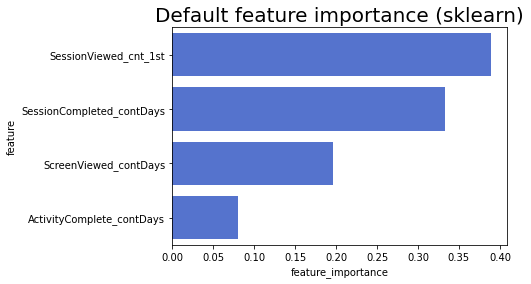

In [62]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
var_imp_plot(base_imp, 'Default feature importance (sklearn)')

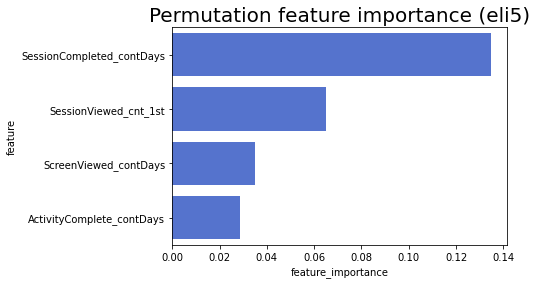

In [63]:
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

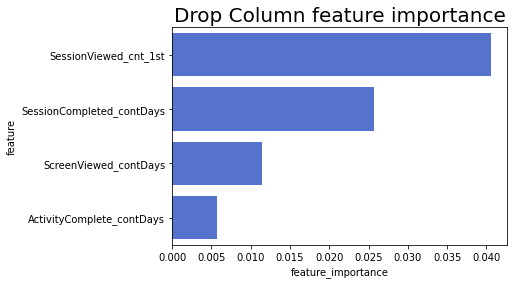

In [64]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    importances_df = imp_df(X_train.columns, importances)
    return importances_df
drop_imp = drop_col_feat_imp(rf, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

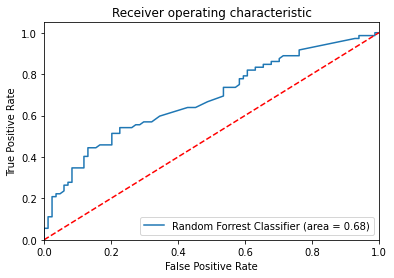

In [65]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Random Forrest Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('../results/AUROC.png', bbox_inches='tight',dpi=100, transparent = True)

In [69]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.feature_names, iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

# Visualize decision path of the model

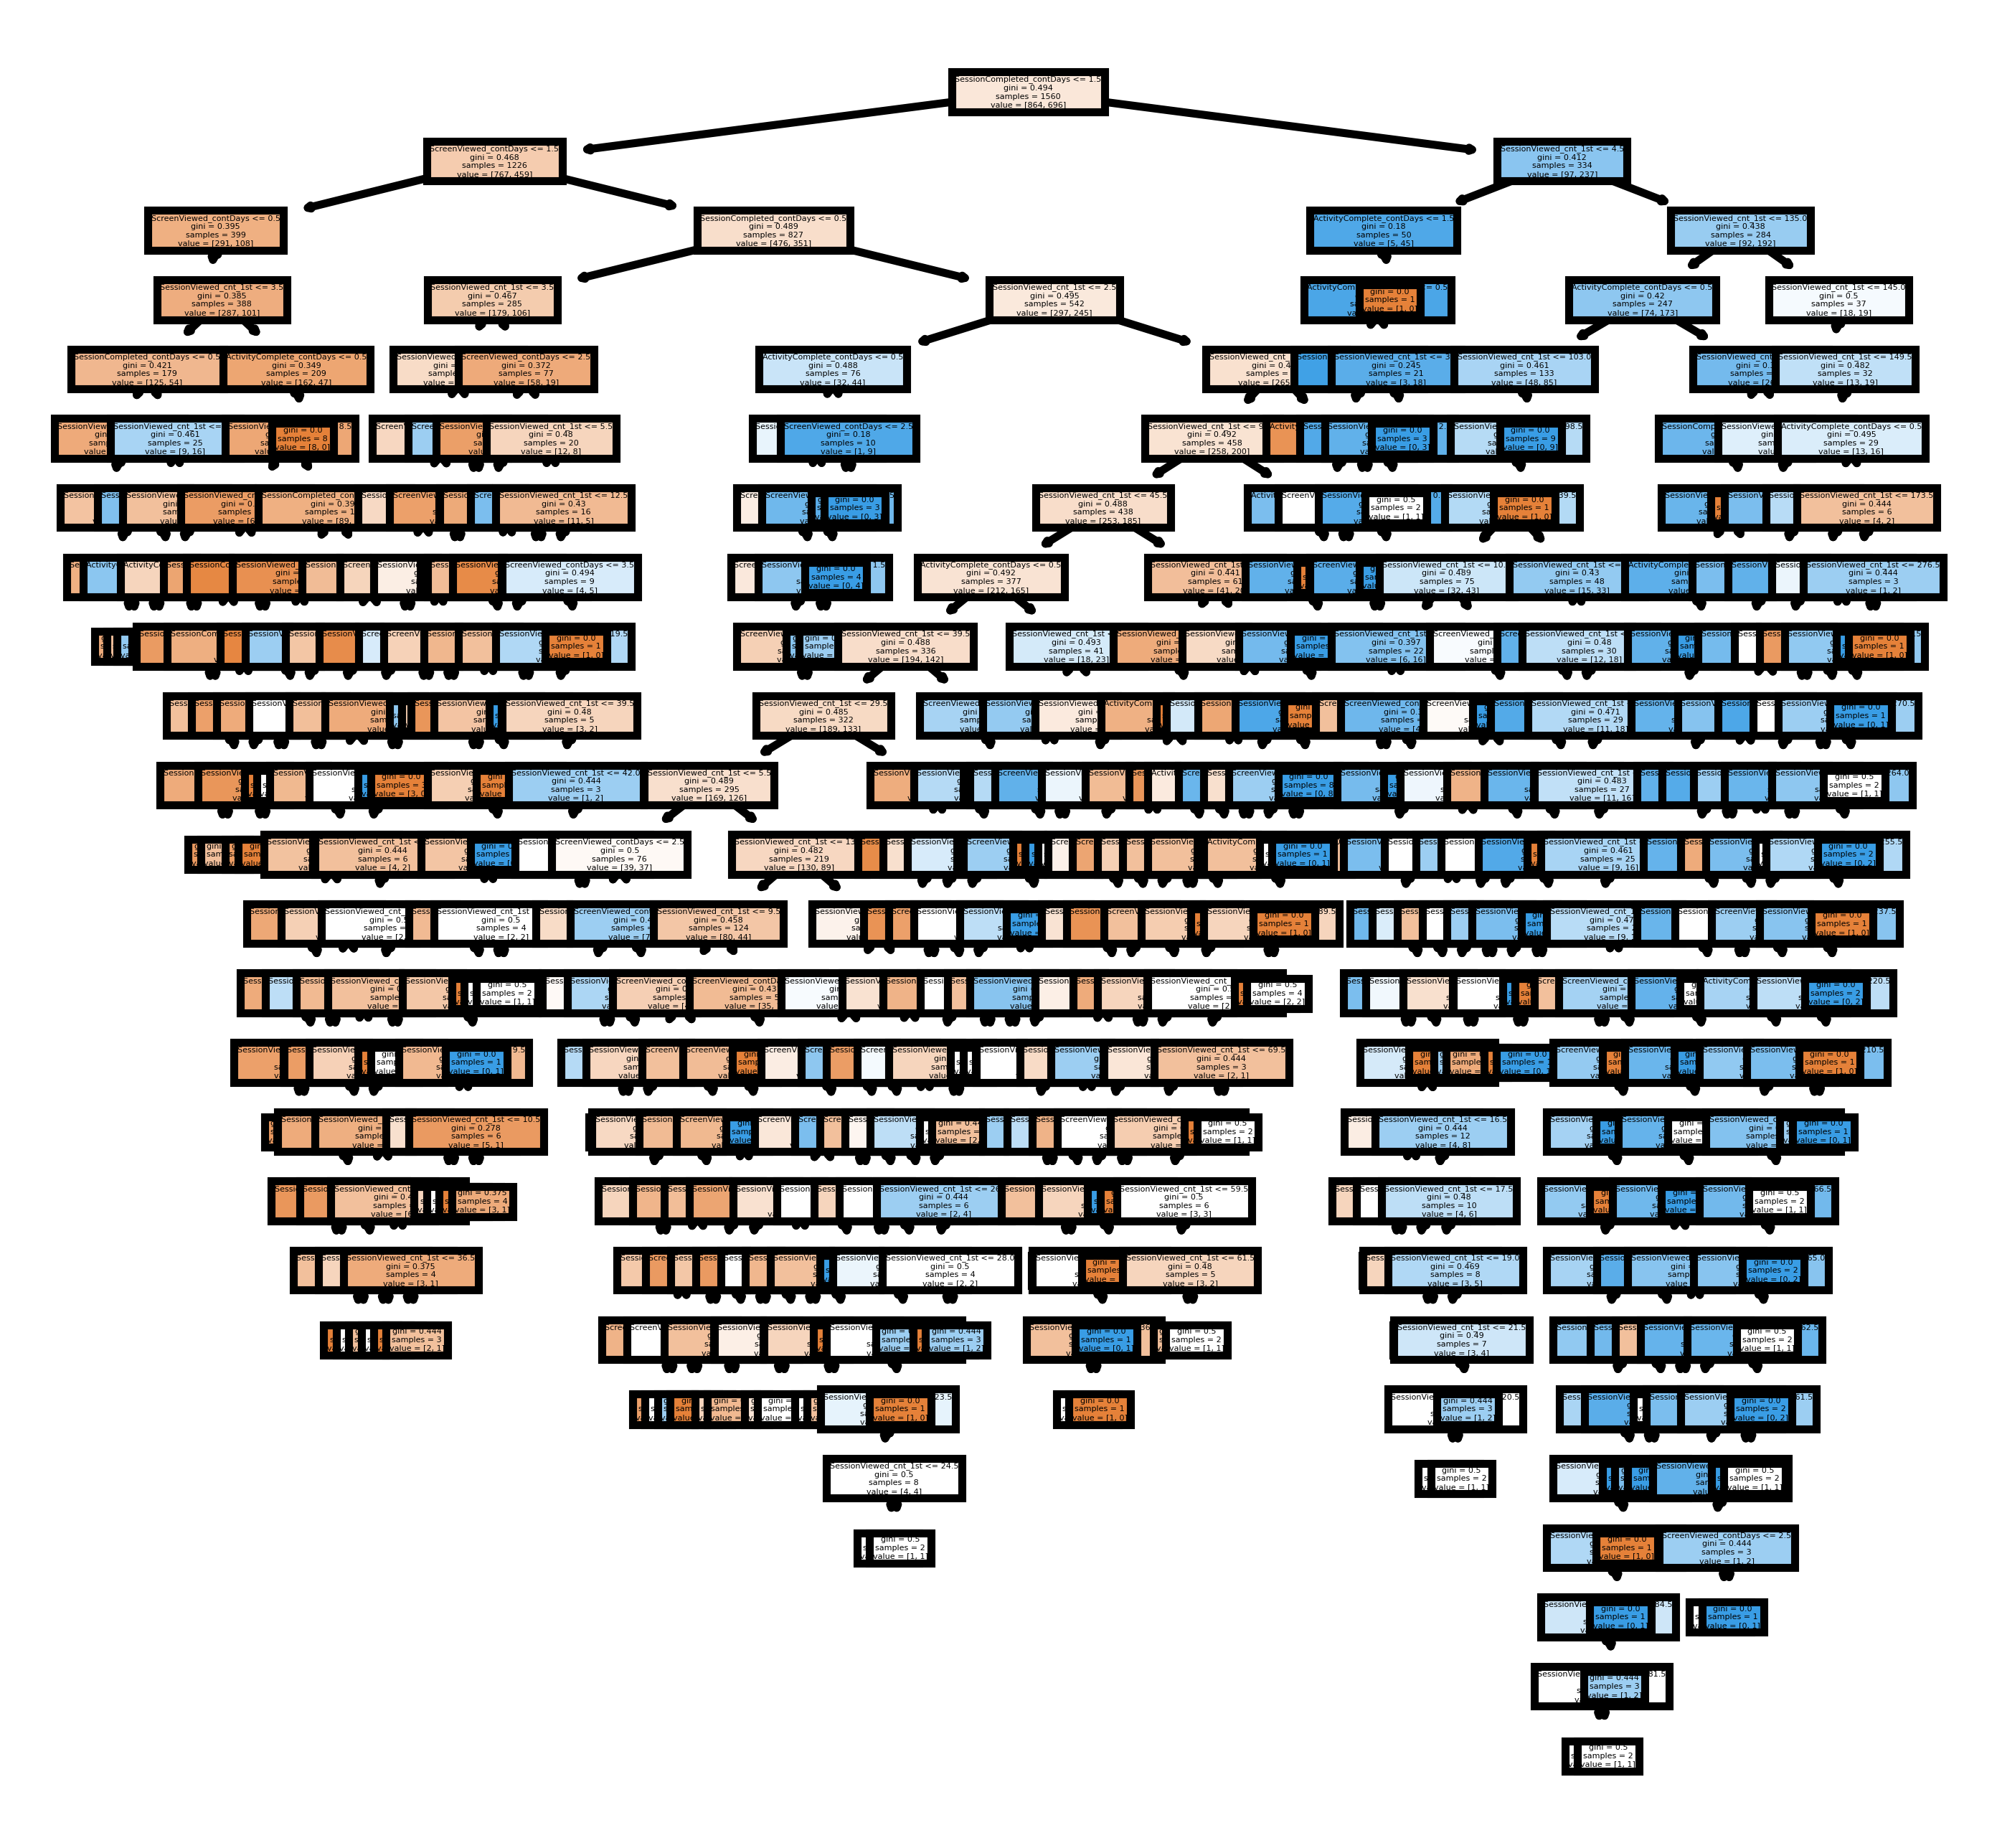

In [96]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf, feature_names = X.columns, filled = True)
fig.savefig('../results/rf_individualtree.png')

In [103]:
# fit the whole data
model=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=6, criterion='gini', oob_score = True)
model.fit(X, y)

RandomForestClassifier(max_depth=6, oob_score=True, random_state=42)

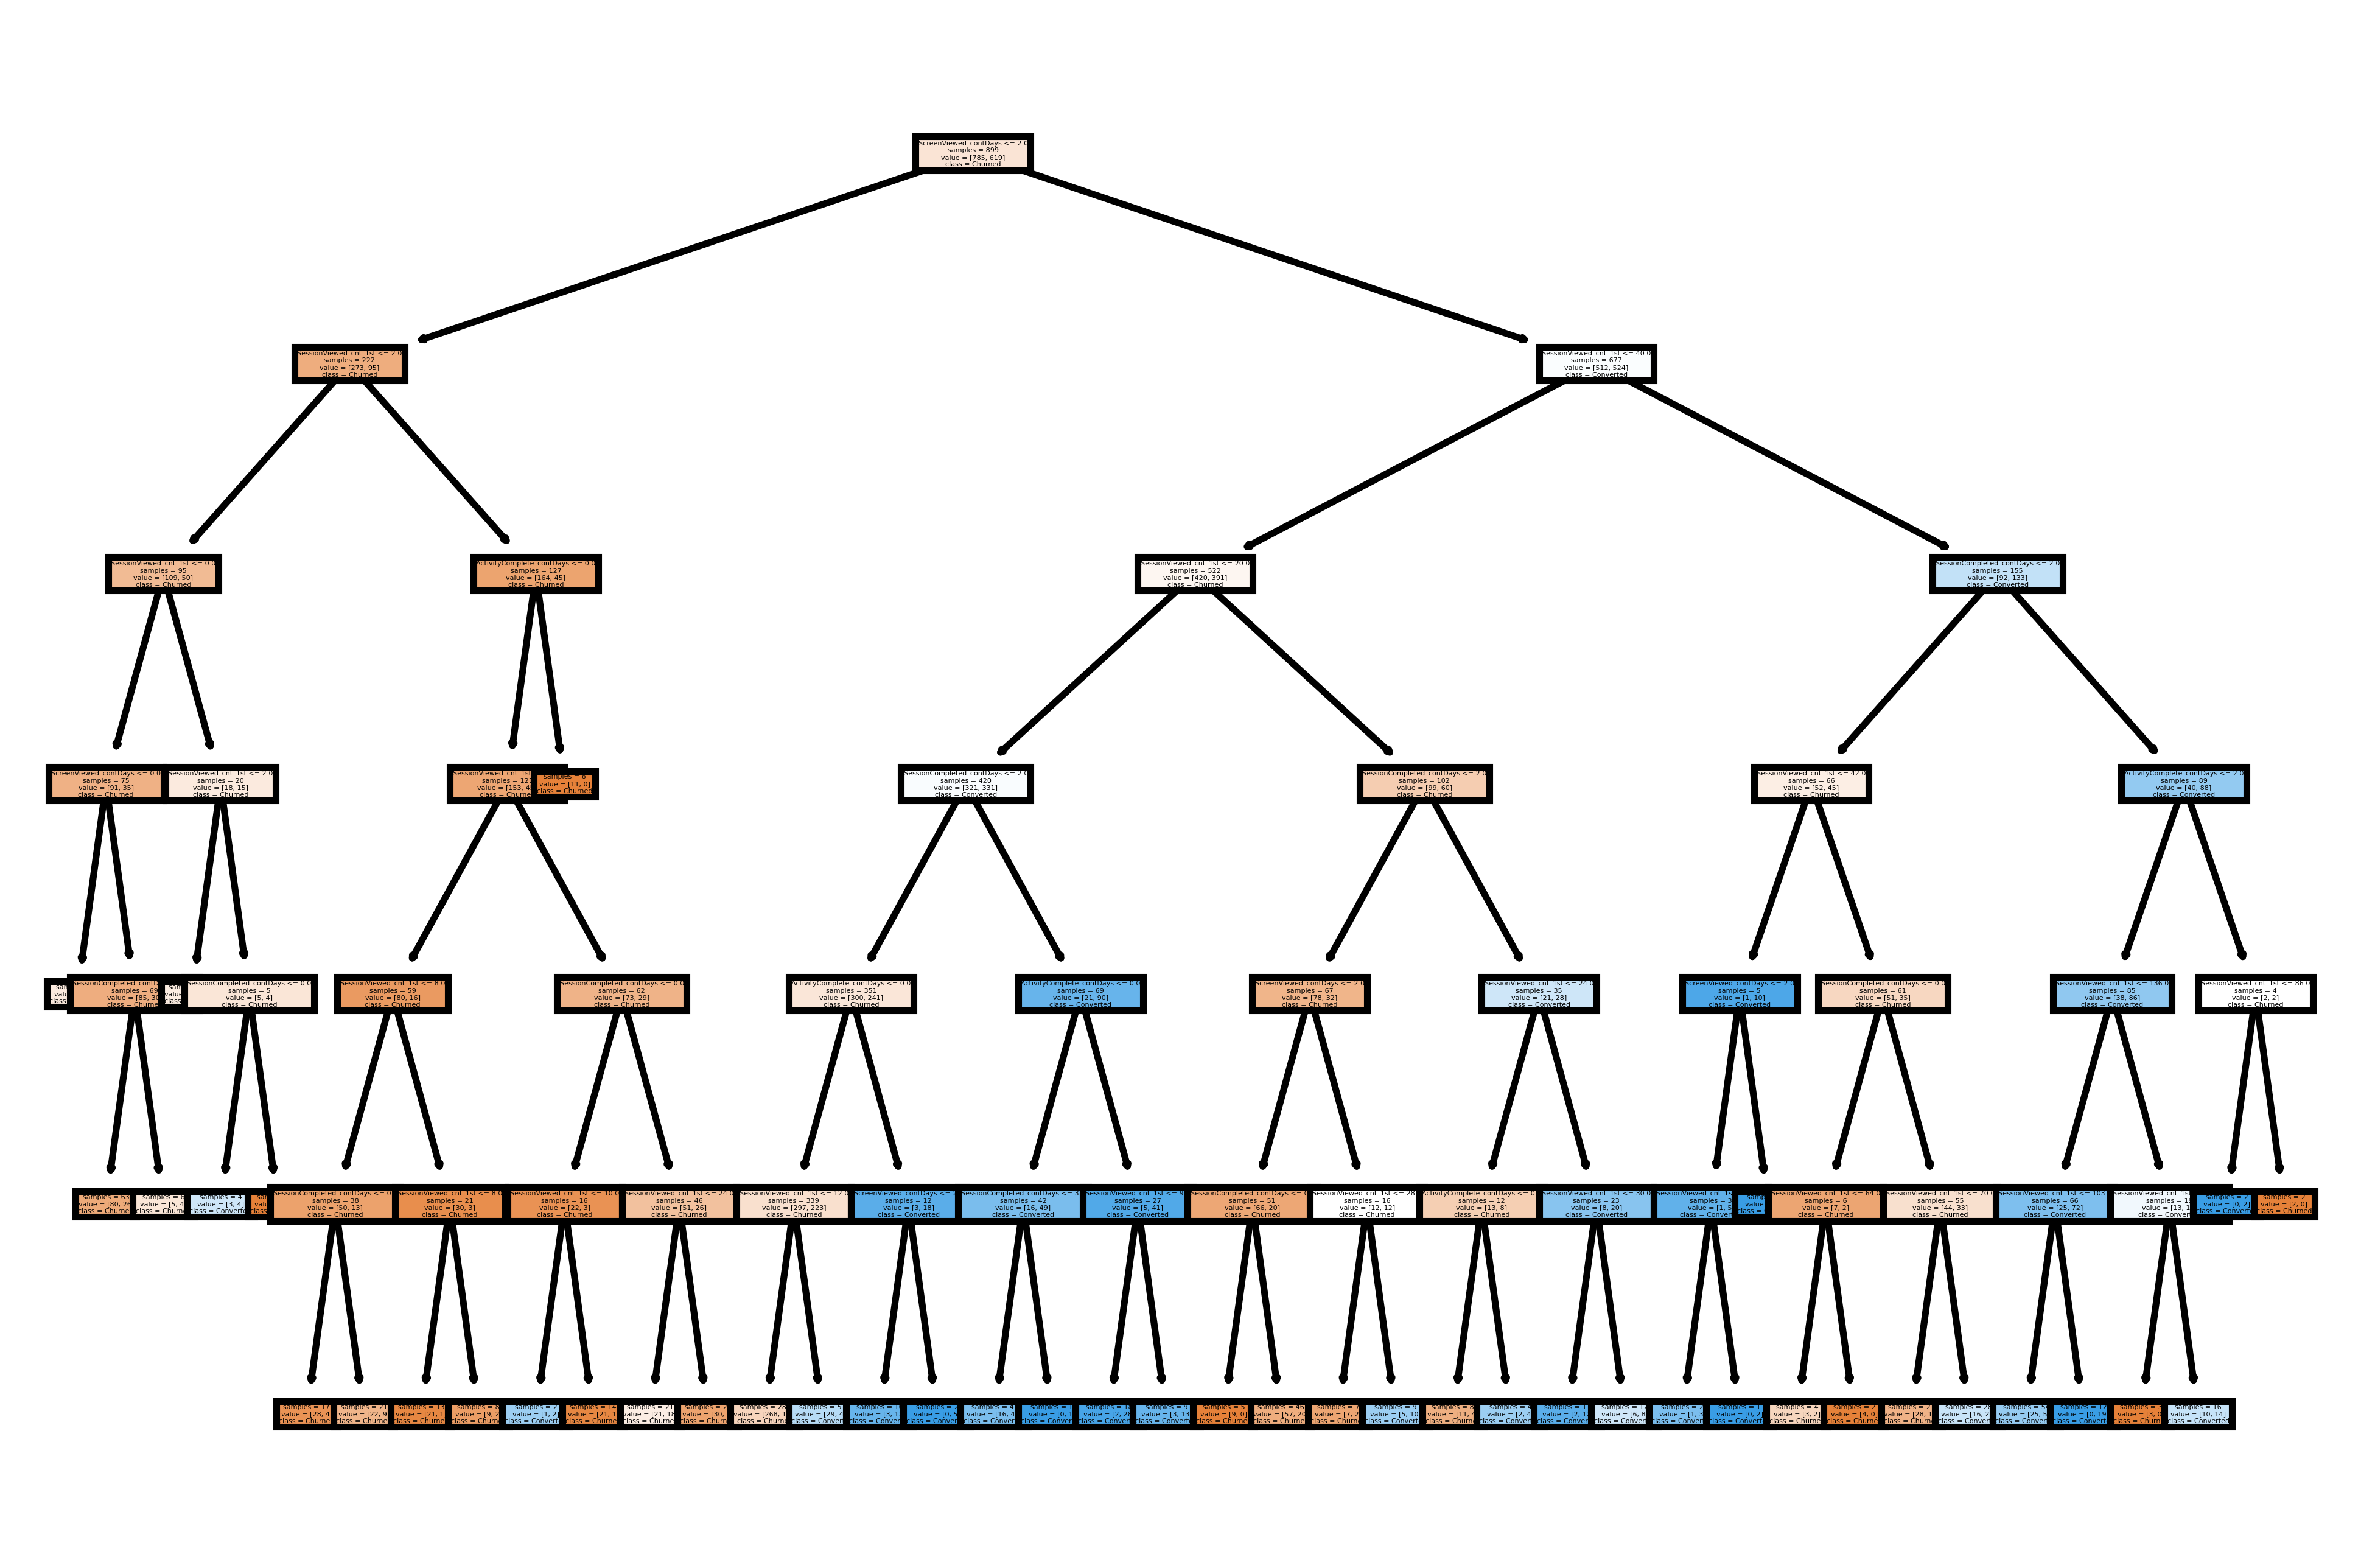

In [110]:
# Extract single tree
estimator = rf.estimators_[2]
# Export as dot file
fig, axes = plt.subplots(nrows = 1, ncols = 1, dpi=800)
tree.plot_tree(estimator,
               feature_names = list(X.columns),
               class_names = ['Churned', 'Converted'],
               filled = True, precision = 0, impurity = False)
fig.savefig('../results/rf_individualtree.png')

In [111]:
# Order for class_names: False = Churned, True = Converted
#sorted(y.unique()) #[False, True]

[False, True]

In [119]:
dot_data = tree.export_graphviz(estimator, out_file=None, 
                     feature_names=list(X.columns),  
                     class_names=['Churned', 'Converted'],  
                     filled=True, rounded=True,  
                     special_characters=True, precision = 0, impurity = False)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("../results/RF_decision.pdf")

True